<a href="https://colab.research.google.com/github/samuel-verburg/EEA-summer-school-2025/blob/main/exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### EAA Summer School 2025: Measurement Methods for Sound Field Analysis, Reconstruction, and Reproduction
**Exercise 2: Machine learning and Physics-informed neural networks for sound field reconstruction**

**Introduction**

Machine learning (ML) has transformed the field of acoustics by enabling data-driven solutions to complex problems such as source localization, speech processing, bioacoustics, sound classification, spatial audio, and room acoustics [Bianco2019]. In particular, the integration of physical principles with ML has been shown to improve the accuracy, efficiency, interpretability, robustness, and generalization capabilities of ML models [Raissi2019].

In this notebook, you will learn to:
- Create a neural network using PyTorch.
- Train a neural network to solve a sound field reconstruction problem.
- Incorporate physical constraints to train a PINN.

To create and train the networks, we are going to use [`PyTorch`](https://pytorch.org/). We run the models on CPU, but the notebook can be easily modified to run on GPU. Just define your device with something like

`device = 'cuda:0' if torch.cuda.is_available() else 'cpu'`

and move the tensors to and from the device.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch as torch
import torch.nn as nn
from tqdm import tqdm

**Creating a neural network class**

The following code defines a fully connected network (FCN) class using PyTorch's `nn.Module`, which is the base class for all neural networks in PyTorch. In the fully connected architecture, each neuron in one layer is connected to every neuron in the next layer.

<img src="https://github.com/samuel-verburg/EEA-summer-school-2025/blob/main/FCN.png?raw=1" alt="Fully Connected Network architecture" width="400"/>

Fig. from [Tonello2019]

The inputs to create a network are:
- `n_in`: Number of input features.
- `n_out`: Number of output features.
- `n_units`: Number of hidden units per layer.
- `n_layers`: Total number of layers (including input and output layers).

We will use *sines* as the activation function. Using sines is beneficial for tasks involving learning high-frequency functions or representing complex signals because they are periodic, smooth, and infinitely differentiable. This allows the network to model continuous signals more effectively than traditional activations like ReLU or tanh. The sine function is not a standard PyTorch activation, so we need to define it first.

Then we define the different layers:

- The first layer is a linear transformation from `n_in` to `n_units`, followed by the sine activation.
- Then comes a sequence of `n_layers-1` hidden layers, each with a linear transformation from `n_units` to `n_units`, followed by the sine activation.
- The final output layer is a linear mapping from `n_units` to `n_out`.

Finally, the function `forward` describes how an input `r` flows through the network:
- Through the first layer (`fcs`).
- Through the hidden layers (`fch`).
- Through the output layer (`fce`).

In [2]:
class Sin(nn.Module):
    """Sin activation function"""
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

class FCN(nn.Module):
    """Fully Connected Network."""
    def __init__(self, n_in, n_out, n_units, n_layers):
        super().__init__()
        activation = Sin
        self.fcs = nn.Sequential(*[
                        nn.Linear(n_in, n_units),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                        nn.Linear(n_units, n_units),
                        activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_units, n_out)
    def forward(self, r):
        r = self.fcs(r)
        r = self.fch(r)
        r = self.fce(r)
        return r

**Generate reference and observed data**

Now we are ready to generate some data. For simplicity, we will work with a 1D+1 problem, i.e., a problem with one spatial dimension $r$ and time $t$. This could be useful, for example, if we want to study the pressure radiated by a source in the radial direction as a function of time.

The pressure field we consider is the one generated by a simple point source:

$$
p(r,t) = \frac{\text{Re}[\text{e}^{\text{j}(\omega t - kr)}]}{4 \pi r} = \frac{\cos(\omega t - kr)}{4 \pi r}
$$

We define points uniformly sampled over $r$ and $t$, and compute the field at these points. This will be the reference.

In [3]:
# Define parameters
c = 343.0
f = 1000.0
k = 2 * np.pi * f / c
L = 1.0
T = 1e-3

r = np.linspace(0.1, L, 50)
t = np.linspace(0, T, 50)
r_grid, t_grid = np.meshgrid(r, t)
rt = np.array([r_grid.flatten(), t_grid.flatten()]).T

p_ref = np.exp(1j * (2 * np.pi * f * rt[:, 1] - k * rt[:, 0])) / (4 * np.pi * rt[:, 0])
p_ref = p_ref.real.reshape(r_grid.shape)

To simulate measurements, we take uniformly spaced samples from the original `r`. The factor `skip` determines the step size for subsampling the spatial dimension. For example, `skip = 7` means that we take every 7th value of `r` to simulate sparse measurements, resulting in a total of 8 measurements.

To increase the difficulty of the problem, a significant amount of noise is added to the observed data.

Finally, we create an animation of the reference and observed data.

In [4]:
np.random.seed(42) # For reproducibility
torch.manual_seed(42) # For reproducibility

skip = 7
p_obs = p_ref[:, 0::skip].copy()
r_obs = r[0::skip]
rt_obs = np.array([r_grid[:, 0::skip].flatten(), t_grid[:, 0::skip].flatten()]).T

# Add noise to observations
p_obs += 0.2 * np.random.randn(p_obs.shape[0],p_obs.shape[1]) * np.sqrt(np.mean(np.abs(p_obs)**2))

# Make an animation
fig = plt.figure(figsize=(6, 4))
line, = plt.plot(r, p_ref[0, :], label='Reference')
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

scatter = plt.scatter(r_obs, p_obs[0, :], color='red', label='Observations')
plt.legend()

def update(frame):
    line.set_ydata(p_ref[frame, :])
    scatter.set_offsets(np.c_[r_obs, p_obs[frame, :]])
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line, scatter

ani = FuncAnimation(fig, update, frames=p_ref.shape[0], interval=100, blit=True)
html = HTML(ani.to_jshtml())
display(html)
plt.close()

**Define the neural network**

We are going to use a neural network to learn the sound field from noisy observations. First, we will train the network *without* physical constraints. In the next section, we will integrate physical knowledge into the training and compare the results.

To work with PyTorch, we first need to convert the NumPy arrays into PyTorch tensors. A PyTorch tensor is a multi-dimensional array used for storing and manipulating data in deep learning models, with support for automatic differentiation and GPU acceleration. As mentioned in the introduction, we will only use the CPU in this example, but we still need to use tensors. Since we need to compute gradients with respect to the input and data tensors, we set `requires_grad_(True)`. This tells PyTorch to track all operations on those tensors.

We want to use the neural network to reconstruct the sound field from the observations. Therefore, we define a network with two inputs, $r$ and $t$, and one output, $p$. For simplicity and to speed up training, we define a small number of layers and a small number of units per layer. Note that more complex signals in higher dimensions (e.g., sound fields in 2D and 3D, room impulse responses, or complex radiation problems) will require larger networks.

Before starting training, we need to choose a loss function. One of the most common losses is the mean squared error (MSE), for which the loss function looks like
$$
\mathcal{L}_\text{obs}(\theta) = \frac{1}{n_\text{obs}} \sum_{i=0}^{n_\text{obs}-1} (p_\theta(r_i,t_i) - p_\text{obs}(r_i,t_i))^2
$$
where $p_\theta(r_i,t_i)$ is the network output for inputs $r_i,t_i$. The subscript indicates that the output is parameterized by the network parameters $\theta$. This loss function is what the optimizer will try to minimize during training. In gradient-based optimization, we tweak the parameters $\theta$ in the direction that minimizes the loss function. [3Blue1Brown has a series of videos](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=2Bx-VUrRQldL3ahC) that cover the basics of neural network training, gradient descent, and backpropagation.

For the optimizer, we choose [ADAM](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html), which is also very common.

In [5]:
rt_obs = torch.tensor(rt_obs, dtype=torch.float32).requires_grad_(True)
p_obs = torch.tensor(p_obs.reshape(-1,1), dtype=torch.float32).requires_grad_(True)
rt = torch.tensor(rt, dtype=torch.float32).requires_grad_(True)

n_in = 2
n_out = 1
n_hidden = 32
n_layers = 3
model = FCN(n_in, n_out, n_hidden, n_layers)

n_epochs = int(4e4)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

**Train the neural network**

We are ready to start training.  
Let's break down the following code cell:

- **Loop over epochs**: `for i in tqdm(range(n_epochs)):` iterates over the number of training epochs. `tqdm` provides a progress bar for visual feedback.

- **Zero the gradients**: `optimizer.zero_grad()` clears old gradients from the previous step. This is necessary because PyTorch accumulates gradients by default.

- **Forward pass**: `p = model(rt_obs)` feeds the input `rt_obs` through the network to get the predictions `p`.

- **Compute the loss**: `loss = mse_loss(p, p_obs)` calculates the mean squared error between predictions `p` and target values `p_obs`.

- **Backward pass**: `loss.backward()` computes gradients of the loss with respect to model parameters using backpropagation.

- **Update parameters**: `optimizer.step()` updates model parameters using the computed gradients.

- **Track loss history**: Initializes `loss_history` on the first iteration and appends the current loss value to the history list. This will serve later to check the training dynamics.

- **Print progress**: Every 5000 epochs, prints the current loss to monitor training progress.

You can stop and resume training at any time.

In [6]:
for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    p = model(rt_obs)
    loss = mse_loss(p, p_obs)
    loss.backward()
    optimizer.step()

    if i == 0:
        loss_history = []
    loss_history.append(loss.item())

    if i % 5000 == 0:
      print('Loss:', loss.item())

  0%|          | 45/40000 [00:00<02:38, 252.22it/s]

Loss: 0.07993398606777191


 13%|█▎        | 5091/40000 [00:09<00:57, 606.92it/s]

Loss: 0.03177253156900406


 25%|██▌       | 10121/40000 [00:18<00:47, 623.76it/s]

Loss: 0.028335552662611008


 38%|███▊      | 15078/40000 [00:26<00:55, 449.58it/s]

Loss: 0.020760737359523773


 50%|█████     | 20098/40000 [00:34<00:34, 585.03it/s]

Loss: 0.004525260534137487


 63%|██████▎   | 25123/40000 [00:44<00:24, 618.96it/s]

Loss: 0.002767921658232808


 75%|███████▌  | 30069/40000 [00:53<00:16, 595.51it/s]

Loss: 0.0023302631452679634


 88%|████████▊ | 35096/40000 [01:01<00:07, 629.69it/s]

Loss: 0.002166913589462638


100%|██████████| 40000/40000 [01:10<00:00, 569.54it/s]


**ex2.0**:

Plot and analyze the training loss history. How does the loss evolve as the network is trained?

/tmp/ipython-input-7-1196013843.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


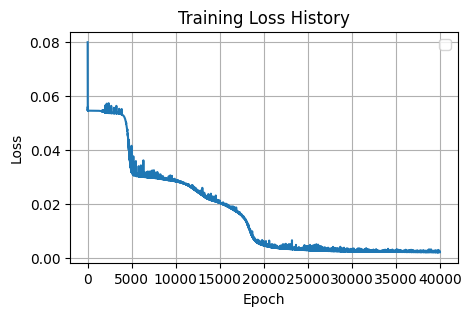

In [7]:
plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()

**ex2.1**:

Make an animation of the pressure predicted over the whole $r$ together with the reference pressure. What can you observe?

To get the estimated pressure, you need to input the tensor `rt` to the network. For plotting, you need to detach it from the computational graph and convert it to a NumPy array. You should reshape the array to make it easier to plot. Altogether, it would look like:

`p_rec = model(rt).detach().numpy()`

`p_rec = p_rec.reshape(r_grid.shape)`

In [8]:
p_rec = model(rt).detach().numpy()
p_rec = p_rec.reshape(r_grid.shape)

fig = plt.figure(figsize=(6, 4))
line1, = plt.plot(r, p_ref[0, :])
line2, = plt.plot(r, p_rec[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line1.set_ydata(p_ref[frame, :])
    line2.set_ydata(p_rec[frame, :])
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line1, line2

ani = FuncAnimation(fig, update, frames=p_rec.shape[0], interval=100, blit=True)
html = HTML(ani.to_jshtml())
display(html)
plt.close()

**Physics-informed neural networks**

You can probably see that the prediction is not very good. Indeed, the problem is quite hard, since we have very few data points and the noise level is high. A network trained only on this data is likely to fail at reconstructing the sound field.

Physics-informed neural networks (PINNs) incorporate physical laws, typically expressed as partial differential equations (PDEs), into the training process. This constrains the network output to not only fit the observed data but also to satisfy the underlying physics of the problem. Since we are dealing with sound fields, we know that the solution must satisfy the wave equation,
$$
\frac{\partial^2 p}{\partial r^2} - \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} = 0.
$$

One can see that to compute the wave equation, we need to take the derivatives of the pressure with respect to $r$ and $t$ twice. The key to PINNs is that such derivatives can be computed automatically using *automatic differentiation*, which allows for exact and efficient differentiation of the neural network's output with respect to its inputs [Baydin2018, Moseley2020].

To train the PINN, the loss function is modified to include the PDE constraint:
$$
\mathcal{L} = \mathcal{L}_\text{obs} + \alpha\mathcal{L}_\text{pde}
$$
where
$$
\mathcal{L}_\text{pde}(\theta) = \frac{1}{n_\text{colloc}} \sum_{i=0}^{n_\text{colloc}-1} \left(\frac{\partial^2 p_\theta (r_i,t_i)}{\partial r^2} - \frac{1}{c^2} \frac{\partial^2 p_\theta (r_i,t_i)}{\partial t^2}\right)^2.
$$
We can see that $\mathcal{L}_\text{pde}(\theta)$ corresponds to the PDE residual.

The points $r_i,t_i$, for $i=0, \dots, n_\text{colloc}$, are sampled over the entire spatial-temporal domain—not only at the observation points. In this way, the PDE constraint is applied over the whole domain, making it possible to predict the pressure at 'unseen' locations. In fact, we are improving the generalization capabilities of the network.

To compute the PDE partial derivatives, we use the function [`torch.autograd.grad`](https://docs.pytorch.org/docs/stable/generated/torch.autograd.grad.html).

In [9]:
def pde_residual(p, rt, c):
    p_rt = torch.autograd.grad(p, rt, torch.ones_like(p), create_graph=True)[0] # dp/dr and dp/dt
    p_rr = torch.autograd.grad(p_rt[:,0], rt, torch.ones_like(p_rt[:,0]), create_graph=True)[0][:,0:1] # d^2p/dr^2
    p_tt = torch.autograd.grad(p_rt[:,1], rt, torch.ones_like(p_rt[:,1]), create_graph=True)[0][:,1:2] # d^2p/dt^2
    pde_res = p_rr - p_tt / c**2
    return pde_res

alpha = 1e-3
model_pinn = FCN(n_in, n_out, n_hidden, n_layers)
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=1e-3)
n_epochs = int(4e4)


Below you can see that training the PINN is very similar to training the previous model. The only difference is that now the loss is composed by two terms: ` loss_obs` and `loss_pde`.

The relative weight is controled by the hyperparameter `alpha`. In fact, properly weihting these terms is crucial to the sucess of the training. This can be seen as a 'weakness' of PINNs, since the results can be very sensitive to the choise of `alpha`. Different methods to automatically find the relative weight have been developed, but to keep this example simple, we are just going to make `alpha = 1e-3` manually.

In [10]:

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    p = model_pinn(rt_obs)
    loss_obs = mse_loss(p, p_obs)

    r_colloc = torch.randn_like(rt_obs, dtype=torch.float32, requires_grad=True) * torch.tensor([L, T])
    p = model_pinn(r_colloc)
    loss_pde = mse_loss(pde_residual(p, r_colloc, c), torch.zeros_like(p))

    loss = loss_obs + loss_pde*alpha

    loss.backward()
    optimizer.step()
    if i == 0:
        loss_history = []
        loss_obs_history = []
        loss_pde_history = []

    loss_history.append(loss.item())
    loss_obs_history.append(loss_obs.item())
    loss_pde_history.append(loss_pde.item())

    if i % 5000 == 0:
      print(loss)


  0%|          | 16/40000 [00:00<08:27, 78.72it/s]

tensor(0.1078, grad_fn=<AddBackward0>)


 13%|█▎        | 5025/40000 [00:48<04:25, 131.88it/s]

tensor(0.0515, grad_fn=<AddBackward0>)


 25%|██▌       | 10019/40000 [01:28<03:37, 137.84it/s]

tensor(0.0438, grad_fn=<AddBackward0>)


 38%|███▊      | 15010/40000 [02:09<04:42, 88.38it/s]

tensor(0.0113, grad_fn=<AddBackward0>)


 50%|█████     | 20029/40000 [02:49<02:23, 138.96it/s]

tensor(0.0064, grad_fn=<AddBackward0>)


 63%|██████▎   | 25025/40000 [03:28<01:49, 136.50it/s]

tensor(0.0061, grad_fn=<AddBackward0>)


 75%|███████▌  | 30028/40000 [04:08<01:12, 137.63it/s]

tensor(0.0062, grad_fn=<AddBackward0>)


 88%|████████▊ | 35016/40000 [04:47<00:37, 132.51it/s]

tensor(0.0060, grad_fn=<AddBackward0>)


100%|██████████| 40000/40000 [05:26<00:00, 122.46it/s]


**ex2.2**:

Plot and analyze the training loss history. How do the different terms of the loss evolve as the network is trained?

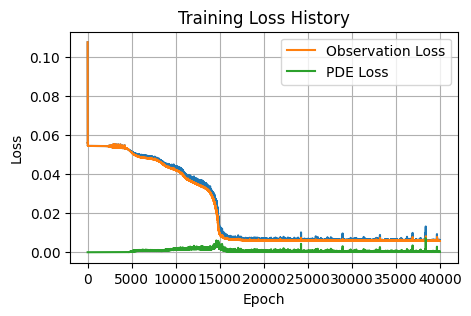

In [11]:
plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history))
plt.plot(np.array(loss_obs_history), label='Observation Loss')
plt.plot(np.array(loss_pde_history)*alpha, label='PDE Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()

**ex2.3**:

Make an animation of the pressure predicted by the PINN over the whole $r$ together with the reference pressure. How do the results compare with the network trained without physics?

In [12]:
p_rec = model_pinn(rt).detach().numpy()
p_rec = p_rec.reshape(r_grid.shape)

fig = plt.figure(figsize=(6, 4))
line1, = plt.plot(r, p_ref[0, :])
line2, = plt.plot(r, p_rec[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line1.set_ydata(p_ref[frame, :])
    line2.set_ydata(p_rec[frame, :])
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line1, line2

ani = FuncAnimation(fig, update, frames=p_rec.shape[0], interval=100, blit=True)
html = HTML(ani.to_jshtml())
display(html)
plt.close()

**Bonus exercises / deliverables**

- You can try to solve a 2D reconstruction problem. You will need to generate data in 2D+1, and the PDE residual should also be modified to account for the extra dimension. Note that this problem will require larger networks, longer training times, and more observed data.

- An interesting application of PINNs is to estimate parameters of the PDE (e.g., the speed of sound $c$) together with the pressure field. For that, you will need to make $c$ a learnable parameter and optimize it together with the network parameters. It could look something like:

`c0 = 340  # initialize value`

`c = torch.nn.Parameter(c0, requires_grad=True)`

`optimizer = torch.optim.Adam([{'params': model.parameters(), "lr": 1e-3}, {'params': c, "lr": 1e-3}])`


**References**

- [Bianco2019] Bianco, M. J., Gerstoft, P., Traer, J., Ozanich, E., Roch, M. A., Gannot, S., & Deledalle, C. A. (2019). Machine learning in acoustics: Theory and applications. The Journal of the Acoustical Society of America, 146(5), 3590-3628.
- [Raissi2019] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational physics, 378, 686-707.
- [Moseley2020] Moseley, B., Markham, A., & Nissen-Meyer, T. (2020). Solving the wave equation with physics-informed deep learning. arXiv preprint arXiv:2006.11894.
- [Tonello2019] Tonello, A., Letizia, N., Righini, D., and Marcuzzi, F. (2019). Machine Learning Tips and Tricks for Power Line Communications. IEEE Access. 7. 1-1
- [Baydin2018] Baydin, A. G., Pearlmutter, B. A., Radul, A. A., & Siskind, J. M. (2018). Automatic differentiation in machine learning: a survey. Journal of machine learning research, 18(153), 1-43.